In [7]:
# 1. Könyvtárak importálása
import numpy as np                   # numerikus műveletekhez
import pandas as pd                  # adatfeldolgozáshoz
import os                            # fájlok eléréséhez
from sklearn.model_selection import train_test_split # adatok felosztásához
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression       # lineáris regresszióhoz
from sklearn.metrics import mean_squared_error          # teljesítményméréshez
from sklearn.preprocessing import StandardScaler        # adatok standardizálásához
from tensorflow.keras.losses import MeanSquaredError
from scipy.stats import spearmanr, kendalltau # eredmények kiértékelése
import joblib                        # modellek mentéséhez
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf              # neurális háló építéséhez
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# 2. Adatbeolvasás: a fájlok elérési útvonalának beállítása
base_path = "/content/drive/MyDrive/tőzsde/"

# Beolvasáskor mindenhol megőrizzük a RowId oszlopot
stock_prices = pd.read_csv(os.path.join(base_path, "train_files/stock_prices.csv"))
secondary_stock_prices = pd.read_csv(os.path.join(base_path, "train_files/secondary_stock_prices.csv"))
supplemental_prices = pd.read_csv(os.path.join(base_path, "supplemental_files/stock_prices.csv"))
supplemental_secondary_stock_prices = pd.read_csv(os.path.join(base_path, "supplemental_files/secondary_stock_prices.csv"))

# 3. Adatok egyesítése (RowId megőrzésével)
stock_prices_combined = pd.concat([
    stock_prices,
    secondary_stock_prices,
    supplemental_prices,
    supplemental_secondary_stock_prices
], ignore_index=True)

# RowId mentése egy külön oszlopba
stock_prices_combined['RowId'] = stock_prices_combined['RowId'].astype(str)  # Biztosítjuk, hogy szövegként kezelje

In [3]:
# 5. Feature engineering: További jellemzők létrehozása

stock_prices_combined['Daily_Range'] = stock_prices_combined['Close'] - stock_prices_combined['Open']
stock_prices_combined['Mean'] = (stock_prices_combined['High'] + stock_prices_combined['Low']) / 2

# Relatív napi mozgás százalékban
stock_prices_combined['Relative_Range'] = stock_prices_combined['Daily_Range'] / stock_prices_combined['Open']

# Végtelen értékek és NaN-ok kezelése
stock_prices_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_prices_combined.fillna(method='ffill', inplace=True)

# 6. Hiányzó értékek pótlása az egész adathalmazban
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Range', 'Mean', 'Relative_Range']
stock_prices_combined[features] = stock_prices_combined[features].fillna(method='ffill').fillna(method='bfill')

# 7. Az adatok normalizálása (Scaler lehet Standard vagy MinMax)
scaler = StandardScaler()
stock_prices_combined[features] = scaler.fit_transform(stock_prices_combined[features])

# 8. Célváltozó ellenőrzése és adatválasztás
stock_prices_combined.dropna(subset=['Target'], inplace=True)

# 9. Bemeneti változók és célváltozó elkülönítése
X = stock_prices_combined[features]
y = stock_prices_combined['Target']
row_ids = stock_prices_combined['RowId']  # Ezt külön eltároljuk!

<ipython-input-3-0c76df4946b5>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_prices_combined.fillna(method='ffill', inplace=True)
<ipython-input-3-0c76df4946b5>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_prices_combined[features] = stock_prices_combined[features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Készítsünk egy új DataFrame-et, amely tartalmazza az összes feature-t és a Target-et
data_plot = X.copy()
data_plot['Target'] = y

# 1. Korrelációs hőtérkép
plt.figure(figsize=(10, 8))
sns.heatmap(data_plot.corr(), annot=True, cmap='coolwarm')
plt.title("Featurek és Target közötti korreláció")
plt.show()

# 2. Scatter plotok egyenként
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=data_plot[feature], y=data_plot['Target'])
    plt.title(f"{feature} vs Target")
    plt.xlabel(feature)
    plt.ylabel("Target")
    plt.show()

In [9]:
# 9. Adatok felosztása tanító és teszt halmazokra (80%-20% arány)
X_train, X_test, y_train, y_test, row_ids_train, row_ids_test = train_test_split(
    X, y, row_ids, test_size=0.2, random_state=42
)

In [10]:

# 10. Modell 1: Lineáris regresszió
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [13]:
# Hibaszámítás
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# RMSE kiszámítása
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# MAE kiszámítása
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Kiíratás
print(f"RMSE Train: {rmse_train:.4f}, RMSE Test: {rmse_test:.4f}")
print(f"MAE Train: {mae_train:.4f}, MAE Test: {mae_test:.4f}")


RMSE Train: 0.0262, RMSE Test: 0.0261
MAE Train: 0.0156, MAE Test: 0.0156


In [ ]:
# Aktuális rangsorolás a tanító halmazon
train_ranking_actual = pd.DataFrame({
    'RowId': row_ids_train.values,  # Az eredeti RowId-k
    'Actual_Target': y_train.values
})
train_ranking_actual = train_ranking_actual.sort_values(by='Actual_Target', ascending=False)
train_ranking_actual['Actual_Rank'] = np.arange(len(train_ranking_actual))

# Modell előrejelzései a tanító halmazra
train_ranking_pred = pd.DataFrame({
    'RowId': row_ids_train.values,
    'Predicted_Target': y_train_pred
})
train_ranking_pred = train_ranking_pred.sort_values(by='Predicted_Target', ascending=False)
train_ranking_pred['Pred_Rank'] = np.arange(len(train_ranking_pred))

# Összekapcsolás RowId alapján
train_comparison = pd.merge(train_ranking_actual, train_ranking_pred, on='RowId')
print("Tanító halmaz rangsorolásának összehasonlítása:")
print(train_comparison[['RowId', 'Actual_Rank', 'Pred_Rank']])

Tanító halmaz rangsorolásának összehasonlítása:
                 RowId  Actual_Rank  Pred_Rank
0        20191219_6557            0    1236149
1        20220202_6541            1    4024943
2        20171214_3540            2    1782089
3        20200812_1689            3    4114222
4        20200818_1689            4      46393
...                ...          ...        ...
4217251  20170906_6397      4217251    4091211
4217252  20170626_7312      4217252    1242236
4217253  20210330_6628      4217253    4199761
4217254  20200915_7612      4217254    3620261
4217255  20190117_2228      4217255    2905871

[4217256 rows x 3 columns]


Spearman korreláció: 0.0051
Kendall tau korreláció: 0.0035
Hit Rate @ 200: 0.00%
Hit Rate @ 1000000: 26.68%


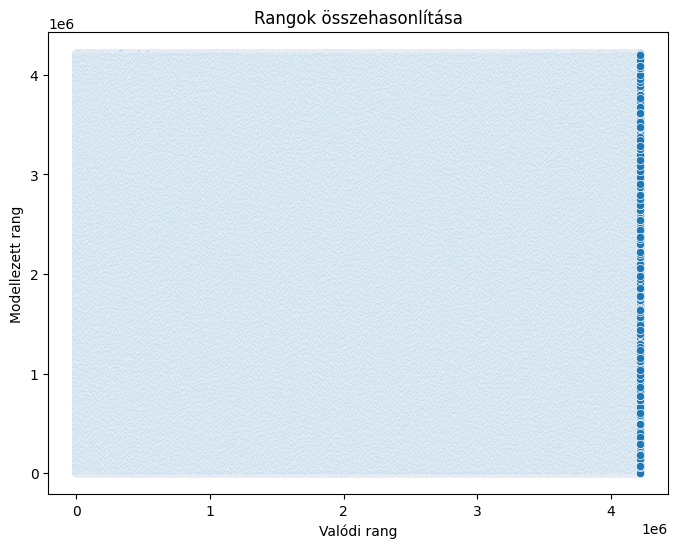

In [ ]:
# Kiértékelés - tanító halmaz

# Spearman és Kendall korreláció kiszámítása
spearman_corr, _ = spearmanr(train_comparison['Actual_Rank'], train_comparison['Pred_Rank'])
kendall_corr, _ = kendalltau(train_comparison['Actual_Rank'], train_comparison['Pred_Rank'])

# Hit Rate @ k kiszámítása
def hit_rate_at_k(test_df, k=10):
    top_k_actual = set(test_df.nsmallest(k, 'Actual_Rank')['RowId'])
    top_k_pred = set(test_df.nsmallest(k, 'Pred_Rank')['RowId'])
    return len(top_k_actual & top_k_pred) / k

hit_rate_5 = hit_rate_at_k(train_comparison, k=200)
hit_rate_10 = hit_rate_at_k(train_comparison, k=1000000)

# Metrikák kiírása
print(f"Spearman korreláció: {spearman_corr:.4f}")
print(f"Kendall tau korreláció: {kendall_corr:.4f}")
print(f"Hit Rate @ 200: {hit_rate_5:.2%}")
print(f"Hit Rate @ 1000000: {hit_rate_10:.2%}")

# Rangok vizualizálása
plt.figure(figsize=(8,6))
sns.scatterplot(x=train_comparison['Actual_Rank'], y=train_comparison['Pred_Rank'])
plt.xlabel("Valódi rang")
plt.ylabel("Modellezett rang")
plt.title("Rangok összehasonlítása")
plt.show()

In [ ]:
# Aktuális rangsorolás a teszthalmazon
test_ranking_actual = pd.DataFrame({
    'RowId': row_ids_test.values,
    'Actual_Target': y_test.values
})
test_ranking_actual = test_ranking_actual.sort_values(by='Actual_Target', ascending=False)
test_ranking_actual['Actual_Rank'] = np.arange(len(test_ranking_actual))

# Modell előrejelzései a teszt halmazra
test_ranking_pred = pd.DataFrame({
    'RowId': row_ids_test.values,
    'Predicted_Target': y_test_pred
})
test_ranking_pred = test_ranking_pred.sort_values(by='Predicted_Target', ascending=False)
test_ranking_pred['Pred_Rank'] = np.arange(len(test_ranking_pred))

# Összekapcsolás RowId alapján
test_comparison = pd.merge(test_ranking_actual, test_ranking_pred, on='RowId')
print("\nTeszt halmaz rangsorolásának összehasonlítása:")
print(test_comparison[['RowId', 'Actual_Rank', 'Pred_Rank']])


Teszt halmaz rangsorolásának összehasonlítása:
                 RowId  Actual_Rank  Pred_Rank
0        20200923_5781            0     455290
1        20210609_1689            1    1023993
2        20210706_1689            2    1038720
3        20210716_1689            3    1040725
4        20201005_1689            4    1031486
...                ...          ...        ...
1054309  20220125_6541      1054309    1036987
1054310  20170808_6397      1054310     811825
1054311  20200515_3606      1054311     719173
1054312  20200924_7612      1054312    1050586
1054313  20180622_1606      1054313     656841

[1054314 rows x 3 columns]


Spearman korreláció: 0.0032
Kendall tau korreláció: 0.0022
Hit Rate @ 200: 0.00%
Hit Rate @ 1000000: 94.98%


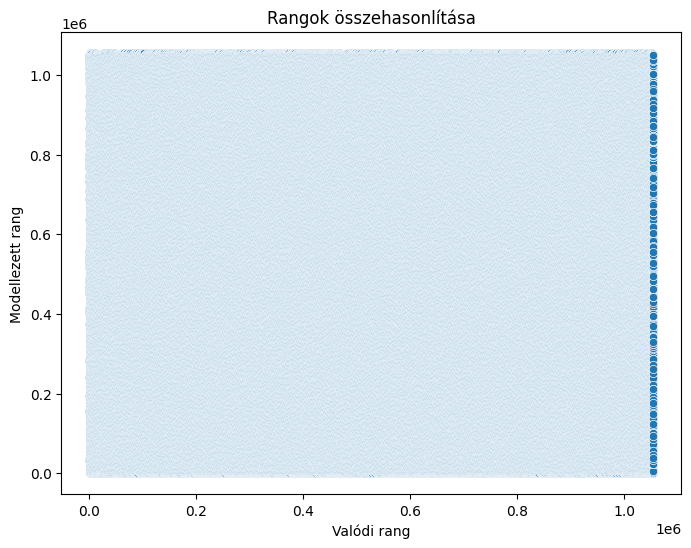

In [ ]:
# Kiértékelés - teszthalmaz

# Spearman és Kendall korreláció kiszámítása
spearman_corr, _ = spearmanr(test_comparison['Actual_Rank'], test_comparison['Pred_Rank'])
kendall_corr, _ = kendalltau(test_comparison['Actual_Rank'], test_comparison['Pred_Rank'])

# Hit Rate @ k kiszámítása
def hit_rate_at_k(test_df, k=10):
    top_k_actual = set(test_df.nsmallest(k, 'Actual_Rank')['RowId'])
    top_k_pred = set(test_df.nsmallest(k, 'Pred_Rank')['RowId'])
    return len(top_k_actual & top_k_pred) / k

hit_rate_5 = hit_rate_at_k(test_comparison, k=200)
hit_rate_10 = hit_rate_at_k(test_comparison, k=1000000)

# Metrikák kiírása
print(f"Spearman korreláció: {spearman_corr:.4f}")
print(f"Kendall tau korreláció: {kendall_corr:.4f}")
print(f"Hit Rate @ 200: {hit_rate_5:.2%}")
print(f"Hit Rate @ 1000000: {hit_rate_10:.2%}")

# Rangok vizualizálása
plt.figure(figsize=(8,6))
sns.scatterplot(x=test_comparison['Actual_Rank'], y=test_comparison['Pred_Rank'])
plt.xlabel("Valódi rang")
plt.ylabel("Modellezett rang")
plt.title("Rangok összehasonlítása")
plt.show()

In [ ]:
# Drive elérési útvonal beállítása
model_save_path = "/content/drive/MyDrive/tőzsde/modellek/"

# Lineáris regressziós modell mentése a Drive-ra
joblib.dump(lin_reg, os.path.join(model_save_path, 'linear_regression_model.pkl'))

['/content/drive/MyDrive/tőzsde/modellek/linear_regression_model.pkl']

In [14]:
# 11. Új feature: a lineáris modell előrejelzéseit hozzáadjuk a bemenethez
# Ez segít a későbbi neurális hálónak, hogy finomítsa az előrejelzést
X_train_enhanced = X_train.copy()
X_test_enhanced = X_test.copy()
X_train_enhanced['Lin_Pred'] = y_train_pred
X_test_enhanced['Lin_Pred'] = y_test_pred

In [ ]:
# 12. Modell 2: Neurális háló (MLP) építése a kiterjesztett jellemzőkkel

# Feltételezzük, hogy az enhanced bemenet input_dim-ja a következő:
input_dim = X_train_enhanced.shape[1]

# Komplexebb modell építése
complex_model = Sequential([

    Dense(2048, activation='relu', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.5),

    Dense(2048, activation='relu', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.5),


    Dense(1024, activation='relu', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.4),

    Dense(1024, activation='relu', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.4),

    Dense(512, activation='relu', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1)  # Kimeneti réteg: regressziós kimenet (Target)
])

# Komplex modell összeállítása
complex_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
complex_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2048)                │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,419,841 (32.12 MB)

 Trainable params: 8,404,097 (32.06 MB)

 Non-trainable params: 15,744 (61.50 KB)

In [ ]:
# 13. Neurális háló tanítása
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Modell tanítása callback-ekkel
history = complex_model.fit(
    X_train_enhanced, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
14827/14827 ━━━━━━━━━━━━━━━━━━━━ 149s 9ms/step - loss: 0.0345 - val_loss: 6.9564e-04 - learning_rate: 0.0010
Epoch 2/50
14827/14827 ━━━━━━━━━━━━━━━━━━━━ 123s 8ms/step - loss: 6.9249e-04 - val_loss: 6.8753e-04 - learning_rate: 0.0010
Epoch 3/50
14827/14827 ━━━━━━━━━━━━━━━━━━━━ 141s 8ms/step - loss: 6.8093e-04 - val_loss: 6.9137e-04 - learning_rate: 0.0010
Epoch 4/50
14827/14827 ━━━━━━━━━━━━━━━━━━━━ 126s 9ms/step - loss: 6.8377e-04 - val_loss: 6.8812e-04 - learning_rate: 0.0010
Epoch 5/50
14827/14827 ━━━━━━━━━━━━━━━━━━━━ 120s 8ms/step - loss: 6.8720e-04 - val_loss: 6.8825e-04 - learning_rate: 0.0010
Epoch 6/50
14827/14827 ━━━━━━━━━━━━━━━━━━━━ 148s 9ms/step - loss: 6.9456e-04 - val_loss: 6.8862e-04 - learning_rate: 0.0010
Epoch 7/50
14827/14827 ━━━━━━━━━━━━━━━━━━━━ 136s 8ms/step - loss: 6.8694e-04 - val_loss: 6.8753e-04 - learning_rate: 5.0000e-04
Epoch 8/50
14827/14827 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - loss: 6.8052e-04 - val_loss: 6.8790e-04 - learning_rate: 5.0000e-04
Epoc

In [ ]:
# Mentjük a neurális háló modellt
complex_model.save(os.path.join(model_save_path, 'neural_network_model.h5'))

In [15]:
# Modellek betöltése
model_save_path = "/content/drive/MyDrive/tőzsde/modellek/"

# Lineáris regressziós modell betöltése
lin_reg = joblib.load(os.path.join(model_save_path, 'linear_regression_model.pkl'))

In [16]:
# Neurális háló modell betöltése
complex_model = tf.keras.models.load_model(
    os.path.join(model_save_path, 'neural_network_model.h5'),
    custom_objects={'mse': MeanSquaredError()}  # Itt explicit megadjuk a mse függvényt
)

# Újra compile-olás az eredeti beállításokkal
complex_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

In [17]:
# Hibaszámítás
y_train_pred_nn = complex_model.predict(X_train_enhanced)
y_test_pred_nn  = complex_model.predict(X_test_enhanced)

# RMSE kiszámítása
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_nn))

# MAE kiszámítása
mae_train = mean_absolute_error(y_train, y_train_pred_nn)
mae_test = mean_absolute_error(y_test, y_test_pred_nn)

# Kiíratás
print(f"RMSE Train: {rmse_train:.4f}, RMSE Test: {rmse_test:.4f}")
print(f"MAE Train: {mae_train:.4f}, MAE Test: {mae_test:.4f}")

131790/131790 ━━━━━━━━━━━━━━━━━━━━ 273s 2ms/step
32948/32948 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step
RMSE Train: 0.0262, RMSE Test: 0.0261
MAE Train: 0.0156, MAE Test: 0.0156


In [ ]:
# Aktuális rangsorolás a tanító halmazon
train_ranking_actual = pd.DataFrame({
    'RowId': row_ids_train.values,  # Az eredeti RowId-k
    'Actual_Target': y_train.values
})
train_ranking_actual = train_ranking_actual.sort_values(by='Actual_Target', ascending=False)
train_ranking_actual['Actual_Rank'] = np.arange(len(train_ranking_actual))

# Modell előrejelzései a tanító halmazra
y_train_pred_nn = y_train_pred_nn.flatten()
train_ranking_pred = pd.DataFrame({
    'RowId': row_ids_train.values,
    'Predicted_Target': y_train_pred_nn
})
train_ranking_pred = train_ranking_pred.sort_values(by='Predicted_Target', ascending=False)
train_ranking_pred['Pred_Rank'] = np.arange(len(train_ranking_pred))

# Összekapcsolás RowId alapján
train_comparison = pd.merge(train_ranking_actual, train_ranking_pred, on='RowId')
print("Tanító halmaz rangsorolásának összehasonlítása:")
print(train_comparison[['RowId', 'Actual_Rank', 'Pred_Rank']])

Tanító halmaz rangsorolásának összehasonlítása:
                 RowId  Actual_Rank  Pred_Rank
0        20191219_6557            0     431275
1        20220202_6541            1     935475
2        20171214_3540            2    2144705
3        20200812_1689            3        214
4        20200818_1689            4    4217243
...                ...          ...        ...
4217251  20170906_6397      4217251    2022589
4217252  20170626_7312      4217252     198093
4217253  20210330_6628      4217253    4192420
4217254  20200915_7612      4217254    2432021
4217255  20190117_2228      4217255     730521

[4217256 rows x 3 columns]


Spearman korreláció: 0.0107
Kendall tau korreláció: 0.0072
Hit Rate @ 200: 0.00%
Hit Rate @ 1000000: 23.12%


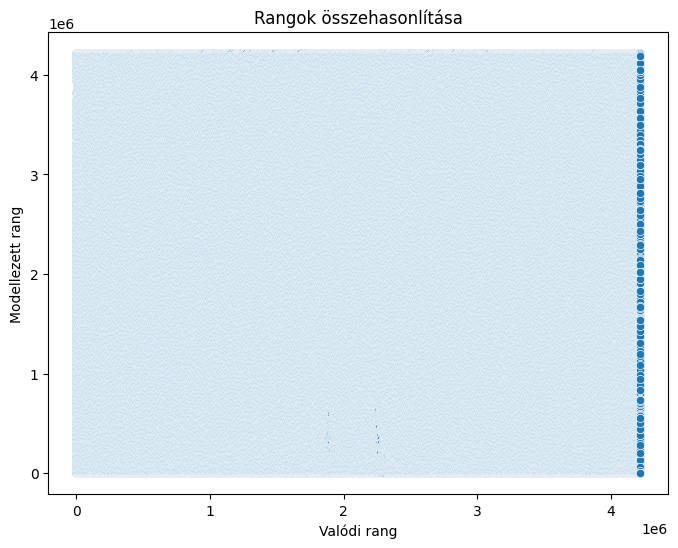

In [ ]:
# Kiértékelés - tanító halmaz

# Spearman és Kendall korreláció kiszámítása
spearman_corr, _ = spearmanr(train_comparison['Actual_Rank'], train_comparison['Pred_Rank'])
kendall_corr, _ = kendalltau(train_comparison['Actual_Rank'], train_comparison['Pred_Rank'])

# Hit Rate @ k kiszámítása
def hit_rate_at_k(test_df, k=10):
    top_k_actual = set(test_df.nsmallest(k, 'Actual_Rank')['RowId'])
    top_k_pred = set(test_df.nsmallest(k, 'Pred_Rank')['RowId'])
    return len(top_k_actual & top_k_pred) / k

hit_rate_5 = hit_rate_at_k(train_comparison, k=200)
hit_rate_10 = hit_rate_at_k(train_comparison, k=1000000)

# Metrikák kiírása
print(f"Spearman korreláció: {spearman_corr:.4f}")
print(f"Kendall tau korreláció: {kendall_corr:.4f}")
print(f"Hit Rate @ 200: {hit_rate_5:.2%}")
print(f"Hit Rate @ 1000000: {hit_rate_10:.2%}")

# Rangok vizualizálása
plt.figure(figsize=(8,6))
sns.scatterplot(x=train_comparison['Actual_Rank'], y=train_comparison['Pred_Rank'])
plt.xlabel("Valódi rang")
plt.ylabel("Modellezett rang")
plt.title("Rangok összehasonlítása")
plt.show()

In [ ]:
# Aktuális rangsorolás a teszt halmazon
test_ranking_actual = pd.DataFrame({
    'RowId': row_ids_test.values,
    'Actual_Target': y_test.values
})
test_ranking_actual = test_ranking_actual.sort_values(by='Actual_Target', ascending=False)
test_ranking_actual['Actual_Rank'] = np.arange(len(test_ranking_actual))

# Modell előrejelzései a teszt halmazra
y_test_pred_nn = y_test_pred_nn.flatten()
test_ranking_pred = pd.DataFrame({
    'RowId': row_ids_test.values,
    'Predicted_Target': y_test_pred_nn
})
test_ranking_pred = test_ranking_pred.sort_values(by='Predicted_Target', ascending=False)
test_ranking_pred['Pred_Rank'] = np.arange(len(test_ranking_pred))

# Összekapcsolás RowId alapján
test_comparison = pd.merge(test_ranking_actual, test_ranking_pred, on='RowId')
print("\nTeszt halmaz rangsorolásának összehasonlítása:")
print(test_comparison[['RowId', 'Actual_Rank', 'Pred_Rank']])


Teszt halmaz rangsorolásának összehasonlítása:
                 RowId  Actual_Rank  Pred_Rank
0        20200923_5781            0     223661
1        20210609_1689            1     488029
2        20210706_1689            2        110
3        20210716_1689            3     422240
4        20201005_1689            4     468411
...                ...          ...        ...
1054309  20220125_6541      1054309     450406
1054310  20170808_6397      1054310       6346
1054311  20200515_3606      1054311     359141
1054312  20200924_7612      1054312    1050717
1054313  20180622_1606      1054313     851185

[1054314 rows x 3 columns]


Spearman korreláció: 0.0100
Kendall tau korreláció: 0.0067
Hit Rate @ 200: 3.00%
Hit Rate @ 1000000: 95.18%


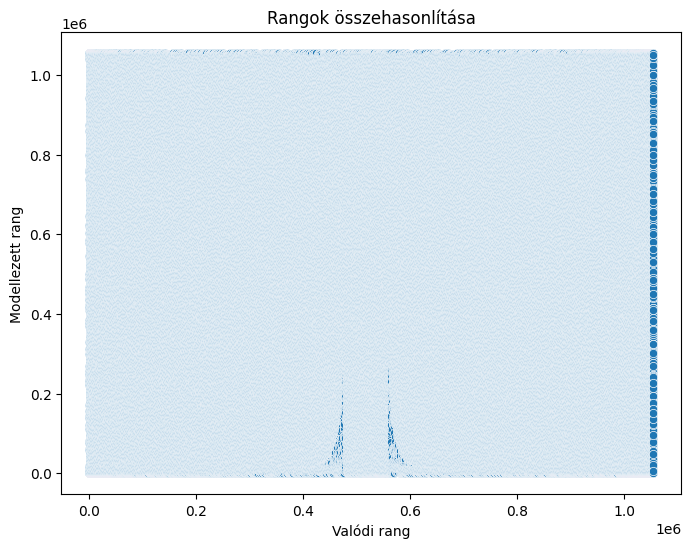

In [ ]:
# Kiértékelés - teszthalmaz

# Spearman és Kendall korreláció kiszámítása
spearman_corr, _ = spearmanr(test_comparison['Actual_Rank'], test_comparison['Pred_Rank'])
kendall_corr, _ = kendalltau(test_comparison['Actual_Rank'], test_comparison['Pred_Rank'])

# Hit Rate @ k kiszámítása
def hit_rate_at_k(test_df, k=10):
    top_k_actual = set(test_df.nsmallest(k, 'Actual_Rank')['RowId'])
    top_k_pred = set(test_df.nsmallest(k, 'Pred_Rank')['RowId'])
    return len(top_k_actual & top_k_pred) / k

hit_rate_5 = hit_rate_at_k(test_comparison, k=200)
hit_rate_10 = hit_rate_at_k(test_comparison, k=1000000)

# Metrikák kiírása
print(f"Spearman korreláció: {spearman_corr:.4f}")
print(f"Kendall tau korreláció: {kendall_corr:.4f}")
print(f"Hit Rate @ 200: {hit_rate_5:.2%}")
print(f"Hit Rate @ 1000000: {hit_rate_10:.2%}")

# Rangok vizualizálása
plt.figure(figsize=(8,6))
sns.scatterplot(x=test_comparison['Actual_Rank'], y=test_comparison['Pred_Rank'])
plt.xlabel("Valódi rang")
plt.ylabel("Modellezett rang")
plt.title("Rangok összehasonlítása")
plt.show()

In [ ]:
def find_rank_by_rowid(comparison_df, row_id):
    result = comparison_df[comparison_df['RowId'] == row_id]
    if result.empty:
        print(f"Nincs találat a(z) {row_id} RowId-ra.")
    else:
        actual_rank = result['Actual_Rank'].values[0]
        pred_rank = result['Pred_Rank'].values[0]
        print(f"RowId: {row_id} -> Valódi rang: {actual_rank}, Prediktált rang: {pred_rank}")

# Példa használat:
row_id_to_search = "20170404_1301"  # Itt add meg a keresett RowId-t!
find_rank_by_rowid(test_ranking_actual, row_id_to_search)